In [1]:
# Core imports
from copy import deepcopy
import os
import math
import importlib
import warnings

# Installed imports
import cvxpy as cp
import matplotlib.pyplot as plt
import mosek
import numpy as np
import torch
from torch.autograd.functional import hessian
from torch.autograd.functional import jacobian

# Local imports
import Driving
from Driving import NavigationDemoLogParser, FrameParsers, driveUtilities
from Driving.NavigationDemoLogParser import NavigationDemoLogParser
import src.learning.training_utils
import src.utils.data_loading
import src.utils.data_processing
import src.utils.experiment_utils
import src.utils.visualization

importlib.reload(src.utils.data_loading)
importlib.reload(src.utils.data_processing)
importlib.reload(src.learning.training_utils)
importlib.reload(src.utils.experiment_utils)
importlib.reload(src.utils.visualization)

from src.learning.training_utils import *
from src.utils.data_loading import *
from src.utils.data_processing import *
from src.utils.experiment_utils import * 
from src.utils.visualization import *

### Set parameters for the continuous IRL problem 

In [ ]:
seconds_per_TR = 2.0045 # generally to have around 
seconds_per_sample = 1/15

# Data parameters 
k_closest_vehicles = 3
k_closest_pedestrians = 0

# Parameters on how to pull out sub-trajectories from demonstrations
length_sub_trajectory = 30
dt_samples_sub_trajectory = 15 
subsample_sub_trajectories = 5 # how widely to space the trajectories you're pulling from the demonstrations  

params = Params(k_closest_vehicles, k_closest_pedestrians, length_sub_trajectory, dt_samples_sub_trajectory, subsample_sub_trajectories, seconds_per_sample)

Start by loading the demonstrations

In [ ]:
# Load the full demonstrations 
train_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/train_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
validation_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/validation_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
test_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/test_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
centerlines = load_centerlines("./Data/LogAndLabelData/map_centerlines.npz")

In [ ]:
 # Pull out just the states, make the centerline direction adjustments, then convert to line frame
 train_demonstration_states_world_frame = [fix_centerline_direction(demonstration[0], k_closest_vehicles, k_closest_pedestrians) for demonstration in train_demonstrations]
 validation_demonstration_states_world_frame = [fix_centerline_direction(demonstration[0], k_closest_vehicles, k_closest_pedestrians) for demonstration in validation_demonstrations]

 train_demonstration_states_line_frame = [line_frame(demonstration_states, k_closest_vehicles, k_closest_pedestrians) for demonstration_states in train_demonstration_states_world_frame]
 validation_demonstration_states_line_frame = [line_frame(demonstration_states, k_closest_vehicles, k_closest_pedestrians) for demonstration_states in validation_demonstration_states_world_frame]

Create a dataset of trajectories pulled from your demonstration

In [ ]:
# Gather sub-trajectories for each demonstration, then stack them 
# into a single matrix of num_sub_trajectories x length_sub_trajectory x num_states
train_subs_per_demonstration = [get_sub_trajectories(demonstration_states, params) for demonstration_states in train_demonstration_states_line_frame]
train_sub_trajectories = np.vstack(train_subs_per_demonstration)

validation_subs_per_demonstration = [get_sub_trajectories(demonstration_states, params) for demonstration_states in validation_demonstration_states_line_frame]
validation_sub_trajectories = np.vstack(validation_subs_per_demonstration)

# Visualize a sub-trajectory
visualize_trajectory(train_sub_trajectories[20, :, :], k_closest_vehicles, k_closest_pedestrians)

TypeError: get_sub_trajectories() missing 2 required positional arguments: 'dt_samples' and 'subsample'

In [ ]:
def f_speedlimit(trajectory, params, speed_limit=35):
    """ 
        The sum of the difference squared between the estimate of speed 
        between each point in the trajectory and the speed_limit. 

        speed_limit is a speed in mph. 
    """
    if trajectory.shape[0] < 2:
        return torch.tensor(0)

    # Pull out relevant parameters 
    dt = params.dt_sub_trajectory

    # Get the position, diff, then speeds in cm/s, and convert to mph
    positions = trajectory[:, 0:2]
    diffs = torch.diff(positions, dim=0)
    speeds_cm_s = torch.linalg.norm(diffs / dt, dim=1)
    speeds_mph = speeds_cm_s * 0.0223694

    print("diffs: ", diffs)
    print("speeds mph: ", speeds_mph)
    print("result: ", torch.sum(torch.square(speeds_mph - speed_limit)))
    return torch.sum(torch.square(speeds_mph - speed_limit)) 

def f_speedlimit_differentiable(positions, rest, params):
    """ 
        A wrapper function for the feature that will allow us to 
        differentiate just with respect to the ego positions in the trajectory
    """
    return f_speedlimit(torch.hstack((positions, rest)), params)

def f_acc(trajectory, params):
    """ 
        The sum of the estimate of acceleration squared
    """
    if trajectory.shape[0] < 3:
        return torch.tensor(0)

    # Pull out relevant parameters
    dt = params.dt_sub_trajectory

    # Get the position, diff, second diff, then acceleration in cm/s^2
    positions = trajectory[:, 0:2]
    diffs_cm_s = torch.diff(positions, dim=0) / dt
    second_diffs_cm_s_s = torch.diff(diffs_cm_s, dim=0) / dt # separately finds x and y acceleration, then combines
    acc_cm_s_s = torch.linalg.norm(second_diffs_cm_s_s, dim=1)

    return torch.sum(torch.square(acc_cm_s_s))

def f_acc_differentiable(positions, rest, params):
    """ 
        A wrapper function for the feature that will allow us to 
        differentiate just with respect to the ego positions in the trajectory
    """
    return f_acc(torch.hstack((positions, rest)), params)

def f_jerk(trajectory, params):
    """
        The sum of the estimate of jerk squared 
    """
    if trajectory.shape[0] < 4:
        return torch.tensor(0)
    # Pull out relevant parameters
    dt = params.dt_sub_trajectory

    # Get the position, diff, second diff, third diff, then jerk in cm/s^3
    positions = trajectory[:, 0:2]
    diffs_cm_s = torch.diff(positions, dim=0) / dt
    second_diffs_cm_s_s = torch.diff(diffs_cm_s, dim=0) / dt
    third_diffs_cm_s_s_s = torch.diff(second_diffs_cm_s_s, dim=0) / dt # separately finds x and y jerk, then combines
    jerk_cm_s_s_s = torch.linalg.norm(third_diffs_cm_s_s_s, dim=1)

    return torch.sum(torch.square(jerk_cm_s_s_s))

def f_jerk_differentiable(positions, rest, params):
    """ 
        A wrapper function for the feature that will allow us to 
        differentiate just with respect to the ego positions in the trajectory
    """
    return f_jerk(torch.hstack((positions, rest)), params)

def f_nearby_vehicles(trajectory, params, width=185, length=470):
    """ 
        The sum of exp(-(x_ego - x_other)^2/width^2 - (y_ego - y_other)^2/length^2)
        for all the nearby vehicles over all moments in time.
    """
    k_closest_vehicles = params.k_closest_vehicles

    total = 0.0
    # Iterate through all the points and vehicles 
    for row_index in range(trajectory.shape[0]):
        ego_position = trajectory[row_index, 0:2]
        for vehicle_index in range(k_closest_vehicles):
            # Get the position of the vehicle then calculate the current term
            vehicle_col = vehicle_index_to_col(vehicle_index)
            vehicle_position = trajectory[row_index, vehicle_col:vehicle_col+2]
            x_diff = ego_position[0] - vehicle_position[0]
            y_diff = ego_position[1] - vehicle_position[1]

            total += torch.exp(-(x_diff**2 / width**2 + y_diff**2 / length**2))
            #total += torch.square(x_diff / width) + torch.square(y_diff / length)

    return total

def f_nearby_vehicles_differentiable(positions, rest, params):
    """ 
        A wrapper function for the feature that will allow us to 
        differentiate just with respect to the ego positions in the trajectory
    """
    return f_nearby_vehicles(torch.hstack((positions, rest)), params)

def f_nearby_pedestrians(trajectory, params):
    """
        The sum of exp(-(x_ego - x_other)^2/width^2 - (y_ego - y_other)^2/length^2)
        for all the nearby pedestrians over all moments in time. 
    """
    k_closest_pedestrians = params.k_closest_pedestrians

    total = 0.0
    # Iterate through all the points and pedestrians
    for row_index in range(trajectory.shape[0]):
        ego_position = trajectory[row_index, 0:2]

        for pedestrian_index in range(k_closest_pedestrians):
            # Get the position of the pedestrian then calculate the current term
            pedestrian_col = pedestrian_index_to_col(pedestrian_index, k_closest_vehicles)
            pedestrian_position = trajectory[row_index, pedestrian_col:pedestrian_col+2]
            x_diff = ego_position[0] - pedestrian_position[0]
            y_diff = ego_position[1] - pedestrian_position[1]
            total += torch.exp(-(x_diff**2 / width**2 + y_diff**2 / length**2))

    return total

def f_nearby_pedestrians_differentiable(positions, rest, params):
    """ 
        A wrapper function for the feature that will allow us to 
        differentiate just with respect to the ego positions in the trajectory
    """
    return f_nearby_pedestrians(torch.hstack((positions, rest)), params)

def f_goal(trajectory, params):
    """
        The distance we have moved during the trajectory along the road  
    """
    start_y = trajectory[0, 1]
    end_y = trajectory[-1, 1]
    return (end_y - start_y)

def f_goal_differentiable(positions, rest, params):
    """ 
        A wrapper function for the feature that will allow us to 
        differentiate just with respect to the ego positions in the trajectory
    """
    return f_goal(torch.hstack((positions, rest)), params)

def f_center_of_lane(trajectory, params, lane_width=1200, width=185):
    """ 
        A gaussian feature capturing your distance from the center of the lane. 
    """

    centerline_index = centerline_col(params.k_closest_vehicles, params.k_closest_pedestrians)
    # assert the centerline is the same throughout the trajectory, and that the x value is the same (we're in the frame where it just goes vertically up)
    assert torch.all(trajectory[:, centerline_index:centerline_index+4] ==  trajectory[0, centerline_index:centerline_index+4])
    assert trajectory[0, centerline_index] == trajectory[0, centerline_index+2] # make sure the x of the first and second point are the same

    centerline_x = trajectory[0, centerline_index]
    lane_center = centerline_x + lane_width / 2

    # Return the sum of distances from the center of the lane
    xs = trajectory[:, 0]
    dist_from_center_scaled = (xs - lane_center)/width
    return torch.sum(torch.exp(-(dist_from_center_scaled**2)))

def f_center_of_lane_differentiable(positions, rest, params):
    """ 
        A wrapper function for the feature that will allow us to 
        differentiate just with respect to the ego positions in the trajectory
    """
    return f_center_of_lane(torch.hstack((positions, rest)), params)

   

In [ ]:
feature_fcns = [f_speedlimit_differentiable, f_acc_differentiable, f_jerk_differentiable, f_nearby_vehicles_differentiable, f_goal_differentiable, f_center_of_lane_differentiable]# [f_speedlimit_differentiable, f_acc_differentiable]# [f_nearby_vehicles_differentiable] #[f_speedlimit_differentiable, f_speedlimit_differentiable, f_acc_differentiable, f_nearby_vehicles_differentiable, f_nearby_pedestrians_differentiable, goal_feature_differentiable]
feature_fcn_labels = ["Speed Limit", "Acceleration", "Jerk", "Nearby Vehicles", "Goal", "Center of Lane"]
n_to_differentiate = 2

train_features = np.zeros((train_sub_trajectories.shape[0], len(feature_fcns)))
for i in range(train_sub_trajectories.shape[0]):
    traj = torch.tensor(train_sub_trajectories[i, :, :])
    for j in range(len(feature_fcns)):
        train_features[i, j] = feature_fcns[j](traj[:, 0:n_to_differentiate], traj[:, n_to_differentiate:], params)

# Get means and stds for each feature 
feat_train_mean, feat_train_std = find_normalization(train_features)

# replace all 0 std with 1 so we don't divide by 0
# and throw a warning that we're doing it
if np.any(feat_train_std == 0):
    warnings.warn("Dividing by 0 std, replacing with 1")
feat_train_std[feat_train_std == 0] = 1

# Weirdly have to do the fcn=fcn to have it stay around during evaluation, otherwise it'll try to call the last thing assigned to fcn
normalized_feature_fcns = [lambda positions, rest, params, fcn=fcn, mean=mean, std=std: (fcn(positions, rest, params) - mean) / std for fcn, mean, std in zip(feature_fcns, feat_train_mean, feat_train_std)]

normalized_features = np.zeros((train_sub_trajectories.shape[0], len(normalized_feature_fcns)))
for i in range(train_sub_trajectories.shape[0]):
    traj = torch.tensor(train_sub_trajectories[i, :, :])
    for j in range(len(normalized_feature_fcns)):
        normalized_features[i, j] = normalized_feature_fcns[j](traj[:, 0:n_to_differentiate], traj[:, n_to_differentiate:], params)


diffs:  tensor([[  -0.6000,  -67.7000],
        [  -1.9000, -258.2000],
        [  -2.2000, -379.0000]], dtype=torch.float64)
speeds mph:  tensor([1.5145, 5.7759, 8.4781], dtype=torch.float64)
result:  tensor(2678.7356, dtype=torch.float64)
diffs:  tensor([[  -1.0000, -132.2000],
        [  -2.3000, -305.1000],
        [  -2.6000, -409.8000]], dtype=torch.float64)
speeds mph:  tensor([2.9573, 6.8251, 9.1672], dtype=torch.float64)
result:  tensor(2487.8939, dtype=torch.float64)
diffs:  tensor([[  -1.4000, -194.2000],
        [  -2.3000, -336.7000],
        [  -2.7000, -408.4000]], dtype=torch.float64)
speeds mph:  tensor([4.3443, 7.5320, 9.1359], dtype=torch.float64)
result:  tensor(2363.2222, dtype=torch.float64)
diffs:  tensor([[  -1.9000, -258.2000],
        [  -2.2000, -379.0000],
        [  -3.3000, -399.8000]], dtype=torch.float64)
speeds mph:  tensor([5.7759, 8.4781, 8.9436], dtype=torch.float64)
result:  tensor(2236.3912, dtype=torch.float64)
diffs:  tensor([[  -2.3000, -305.100

In [ ]:
feat_train_mean
feat_train_std

array([1.17655625e+03, 1.03962535e+05, 6.29965881e+04, 1.85516256e-01,
       1.19683162e+03, 4.50791438e-02])

Any inf in normalized features? False


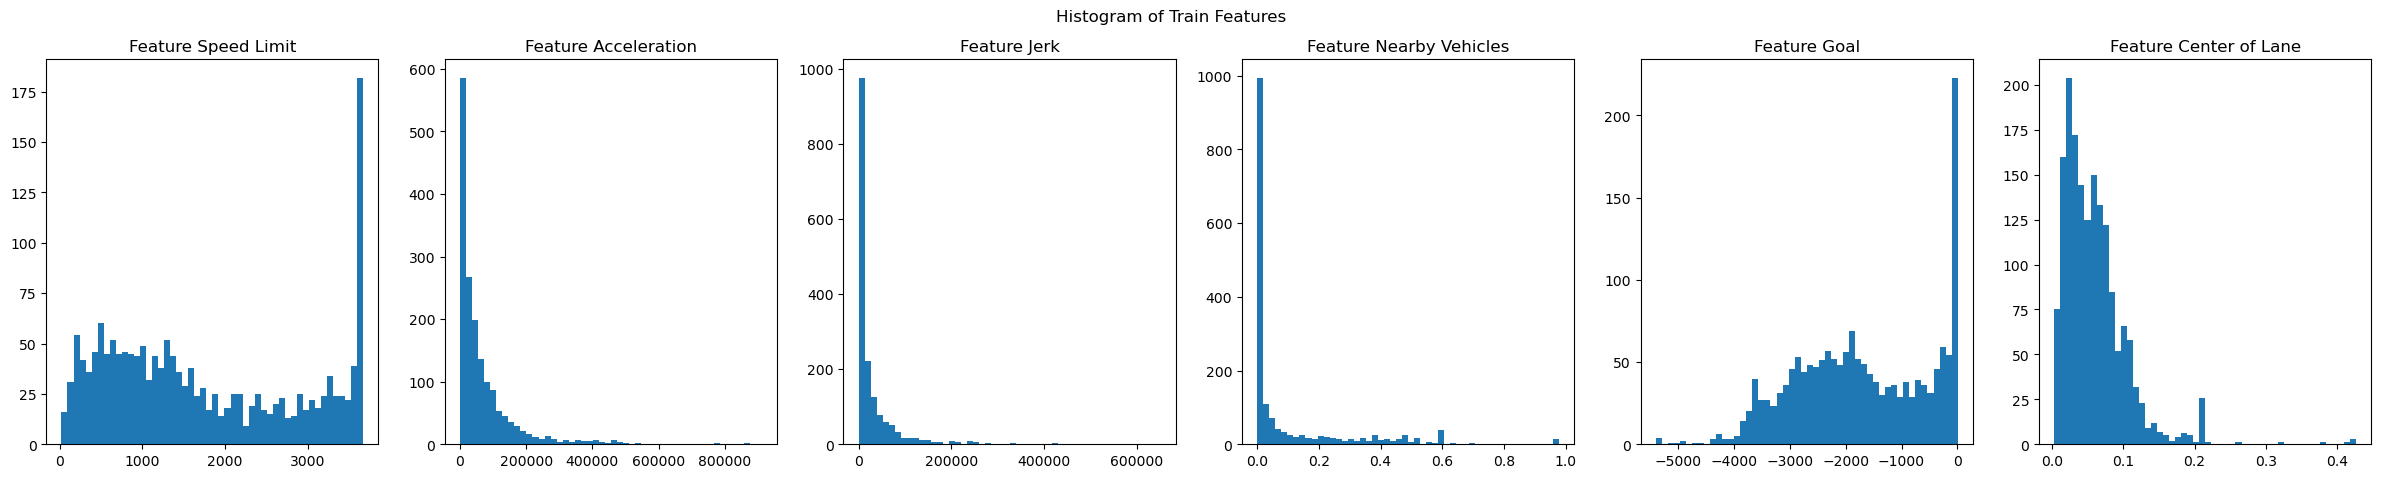

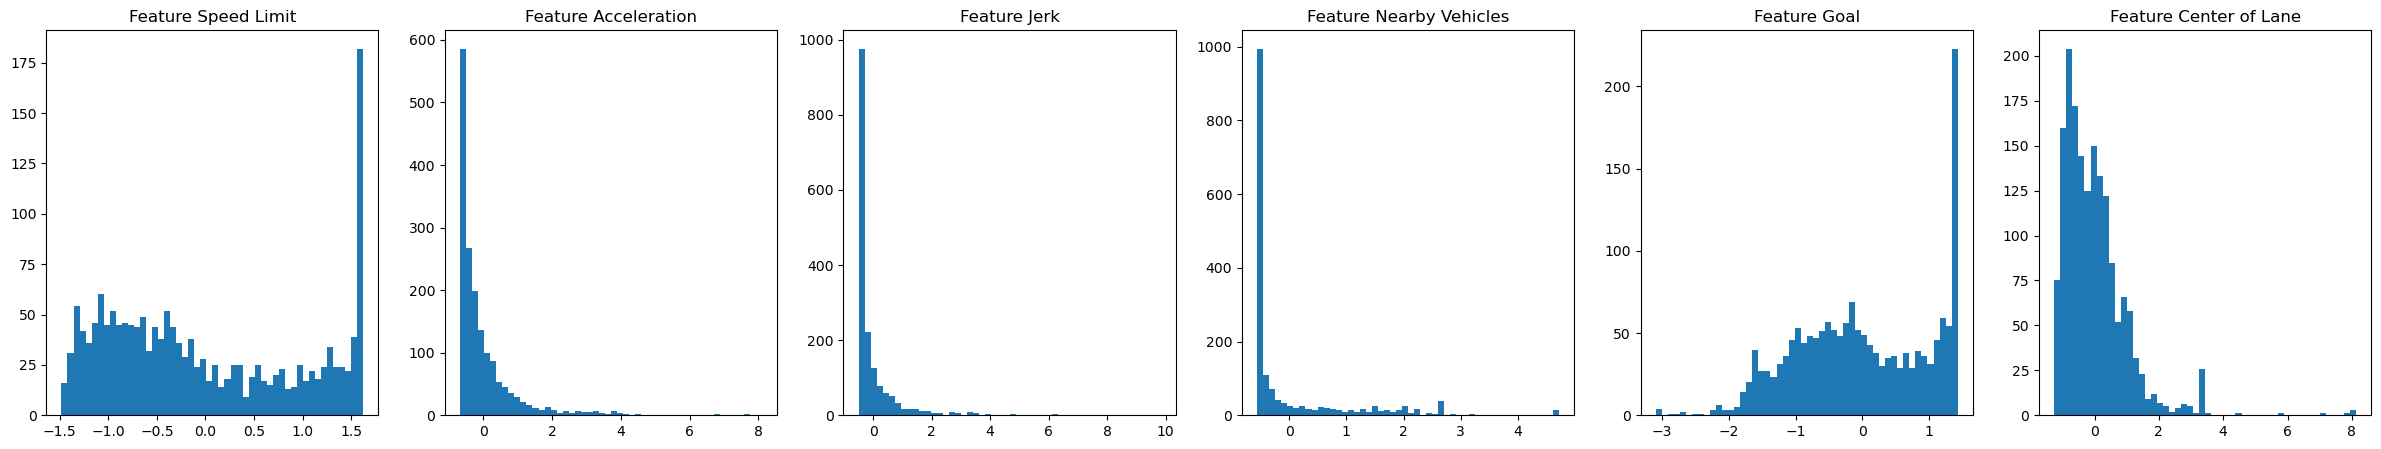

In [ ]:
# Histogram of each train features
plt.subplots(1, train_features.shape[1], figsize=(5*train_features.shape[1], 5))
for i in range(train_features.shape[1]):
    plt.subplot(1, train_features.shape[1], i+1)
    plt.hist(train_features[:, i], bins=50)
    plt.title(f"Feature {feature_fcn_labels[i]}")

# Add a title above all the subplot titles 
plt.suptitle("Histogram of Train Features")

# Histogram of each normalized train features
# print if any inf in normalized features
print("Any inf in normalized features?", np.any(np.isinf(normalized_features)))

plt.subplots(1, normalized_features.shape[1], figsize=(5*normalized_features.shape[1], 5))
for i in range(normalized_features.shape[1]):
    plt.subplot(1, normalized_features.shape[1], i+1)
    plt.hist(normalized_features[:, i], bins=50)
    plt.title(f"Feature {feature_fcn_labels[i]}")

In [ ]:
def continuous_irl(trajectories, feature_fcns, params, n_to_differentiate, beta=1.0):
    objective = 0
    theta = cp.Variable(len(feature_fcns))
    print("len feature fcns: ", len(feature_fcns))
    theta_temp = cp.Variable()
    traj_length = trajectories.shape[1]
    length_vector_rep_to_differentiate = traj_length*n_to_differentiate

    print("Setting up the problem")
    for i in tqdm(range(trajectories.shape[0])):
        trajectory = trajectories[i, :, :]

        H = 0 # cp.Variable((length_vector_rep_to_differentiate, length_vector_rep_to_differentiate), NSD=True)
        g = 0
        constraints = []

        traj_to_differentiate = torch.tensor(trajectory[:, 0:n_to_differentiate], requires_grad=True)
        H_temp = 0
        for j, feature_fcn in enumerate(feature_fcns):
            # Get your hessian, reshape into a 2-dimensional matrix, then add onto our H
            temp_f = functools.partial(feature_fcn, rest=torch.tensor(trajectory[:, n_to_differentiate:]), params=params)
            hess = hessian(temp_f, traj_to_differentiate)
            
            hess_reshaped = hess.reshape((n_to_differentiate*traj_length, n_to_differentiate*traj_length)) # TODO: double check this is reshaping how we'd expect
            H += theta[j] * hess_reshaped
            H_temp += hess_reshaped

            # print if any nan in hess_reshaped 
            if np.any(np.isnan(hess_reshaped.detach().numpy())):
                print("some nan, i, j: ", i, j)


            jac = jacobian(temp_f, traj_to_differentiate)
            jac_reshaped = jac.reshape(length_vector_rep_to_differentiate)
            g += theta[j] * jac_reshaped

        #H += theta_temp * torch.eye(length_vector_rep_to_differentiate)
        print("H temp: ", H_temp)
        # Print rank of H_temp for this demonstration 
        print("Rank of H_temp: ", np.linalg.matrix_rank(H_temp.detach().numpy()))
        # Print the eigenvalues of H_temp
        eigvals, eigvecs = np.linalg.eig(H_temp.detach().numpy())
        for j in range(len(eigvals)):
            print("Eigenvalue ", j, ": ", eigvals[j])
            print("Eigenvector ", j, ": ", eigvecs[:, j])
        # Print the eigenvectors of H_temp 
        #H -= 1e-7 * torch.eye(length_vector_rep_to_differentiate)

        objective += -0.5 * cp.matrix_frac(g, -H) + 0.5 * cp.log_det(-H)
        constraints += [H << 0] # H NSD 

        
    # Create the problem and solve it
    #objective -= 0 * theta_temp**2
    prob = cp.Problem(cp.Maximize(objective), constraints)
    print("Solving")
    result = prob.solve(solver=cp.MOSEK, verbose=True)
    print("Problem status: ", prob.status)

    if prob.status in ["infeasible", "unbounded"]:
        assert False, "Problem infeasible or unbounded"

    return theta.value, theta_temp.value
    

theta, theta_regularizer = continuous_irl(train_sub_trajectories[0:1600:100, :, :], normalized_feature_fcns, params, n_to_differentiate)

len feature fcns:  6
Setting up the problem


  0%|          | 0/16 [00:00<?, ?it/s]

diffs:  tensor([[  -0.6000,  -67.7000],
        [  -1.9000, -258.2000],
        [  -2.2000, -379.0000]], dtype=torch.float64, grad_fn=<SubBackward0>)
speeds mph:  tensor([1.5145, 5.7759, 8.4781], dtype=torch.float64, grad_fn=<MulBackward0>)
result:  tensor(2678.7356, dtype=torch.float64, grad_fn=<SumBackward0>)
diffs:  tensor([[  -0.6000,  -67.7000],
        [  -1.9000, -258.2000],
        [  -2.2000, -379.0000]], dtype=torch.float64, grad_fn=<SubBackward0>)
speeds mph:  tensor([1.5145, 5.7759, 8.4781], dtype=torch.float64, grad_fn=<MulBackward0>)
result:  tensor(2678.7356, dtype=torch.float64, grad_fn=<SumBackward0>)


 19%|█▉        | 3/16 [00:00<00:01, 10.12it/s]

H temp:  tensor([[ 2.3746e-04,  1.7421e-07, -1.1491e-04, -1.7421e-07,  1.1448e-04,
          0.0000e+00, -3.1748e-05,  0.0000e+00],
        [ 1.7421e-07,  5.1835e-05, -1.7421e-07, -1.3457e-04,  0.0000e+00,
          1.1448e-04,  0.0000e+00, -3.1748e-05],
        [-1.1491e-04, -1.7421e-07,  5.6233e-04,  2.1213e-07, -3.5838e-04,
         -3.7927e-08,  1.1448e-04,  0.0000e+00],
        [-1.7421e-07, -1.3457e-04,  2.1213e-07,  3.8362e-04, -3.7927e-08,
         -3.6353e-04, -2.0284e-22,  1.1448e-04],
        [ 1.1448e-04,  0.0000e+00, -3.5838e-04, -3.7927e-08,  5.7298e-04,
          5.8309e-08, -1.3106e-04, -2.0383e-08],
        [-1.9442e-22,  1.1448e-04, -3.7927e-08, -3.6353e-04,  5.8309e-08,
          3.8362e-04, -2.0383e-08, -1.3457e-04],
        [-3.1748e-05,  0.0000e+00,  1.1448e-04,  0.0000e+00, -1.3106e-04,
         -2.0383e-08,  2.4009e-04,  2.0383e-08],
        [ 0.0000e+00, -3.1748e-05, -8.4142e-24,  1.1448e-04, -2.0383e-08,
         -1.3457e-04,  2.0383e-08,  5.1836e-05]], dtype=

 19%|█▉        | 3/16 [00:00<00:01,  7.55it/s]

H temp:  tensor([[        nan,         nan,         nan,         nan,  1.1448e-04,
          0.0000e+00, -3.1748e-05,  0.0000e+00],
        [        nan,         nan,         nan,         nan,  0.0000e+00,
          1.1448e-04,  0.0000e+00, -3.1748e-05],
        [        nan,         nan,         nan,         nan, -2.4801e-04,
          4.0181e-06,  1.1448e-04,  2.6467e-22],
        [        nan,         nan,         nan,         nan,  4.0181e-06,
         -3.6339e-04, -1.4886e-22,  1.1448e-04],
        [        nan,         nan,         nan,         nan,  3.4355e-04,
         -6.6494e-06, -1.2821e-04,  1.0932e-07],
        [        nan,         nan,         nan,         nan, -6.6494e-06,
          3.8657e-04,  1.0932e-07, -1.3457e-04],
        [        nan,         nan,         nan,         nan, -1.2821e-04,
          1.0932e-07,  1.2115e-04, -3.0745e-06],
        [        nan,         nan,         nan,         nan,  1.0932e-07,
         -1.3457e-04, -3.0745e-06,  5.1776e-05]], dtype=

LinAlgError: Array must not contain infs or NaNs

In [ ]:
theta, theta_regularizer

(array([-15.22800597,  -4.00757449,  -8.24354513, -58.06362376,
         19.1908906 ,  -1.65372942]),
 None)

In [ ]:
# sub_1 = train_sub_trajectories[0, :, :]
# sub_1 = torch.tensor(sub_1, requires_grad=True)

# res = f_nearby_vehicles_differentiable(sub_1[:, 0:2], sub_1[:, 2:], params)
# type(res) 

# temp_f = functools.partial(normalized_feature_fcns[0], rest=sub_1[:, 2:], params=params)
# hess = hessian(temp_f, sub_1[:, 0:2])
# print(sub_1[4, 1] - sub_1[3, 1])
# print("hess: ", np.reshape(hess, (10, 10)))
# # print rank of hessian
# print("rank: ", np.linalg.matrix_rank(np.reshape(hess, (10, 10))))

# # find the gradient as well of temp_f 
# grad = jacobian(temp_f, sub_1[:, 0:2])
# print("Feature labels: ", feature_fcn_labels)
# print("grad: ", grad)

In [ ]:
# print out if traj has any nans
traj[:, 0]
traj[:, 1]

array([9249.3, 9249.3])

In [ ]:
# Find the hessian of a particular feature 
feature_index = 0
demonstration_index = 400
traj = train_sub_trajectories[demonstration_index, :, :]
traj = deepcopy(traj)
# noise the traj with a tiny bit of noise uniformly drawn
traj[:, 0:2] += np.random.uniform(-1e-5, 1e-5, traj[:, 0:2].shape)
temp_f = functools.partial(f_speedlimit_differentiable, rest=torch.tensor(traj[:, 2:]), params=params)
hess = hessian(temp_f, torch.tensor(traj[:, 0:2]))
hess_reshaped = hess.reshape((8, 8))

print("hess: ", hess_reshaped)

# Get the eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eig(hess_reshaped)
for i in range(len(eigvals)):
    print("Eigenvalue ", i, ": ", eigvals[i])
    print("Eigenvector ", i, ": ", eigvecs[:, i])

NameError: name 'train_sub_trajectories' is not defined

In [ ]:
# Okay setup a toy example where you're just trying to go from a start to an end point
# and the demonstration is just like a nice linear spacing + noise 
# to try to tease apart whether it's something specific with like our hessians and stuff or not

In [ ]:
for th, label in zip(theta, feature_fcn_labels):
    print(f"{label}: {th}")

Speed Limit: -4.326743039531678
Acceleration: -1.4743829744669903
Jerk: 0.0
Nearby Vehicles: -0.8286753115042725
Goal: 6.177862310982197
Center of Lane: -1.385236527275785


theta:  tensor([ 7.0050e+02, -3.6185e-01, -5.9583e+04, -9.0970e+02],
       dtype=torch.float64)
reward:  tensor(-88584.9145, dtype=torch.float64)
perturbed:  tensor([[  159.1000, 54719.2000],
        [  159.1000, 54719.2000],
        [  159.1000, 54719.2000],
        [  159.1000, 54719.2000],
        [  159.1000, 54719.2000],
        [  159.1000, 54819.2000]], dtype=torch.float64)
reward perturbed:  tensor(-88693.1291, dtype=torch.float64)
grad:  tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64)
diff:  tensor(0., dtype=torch.float64)


(157.77499999999856, 186.92499999999853, 49992.35, 55049.049999999996)

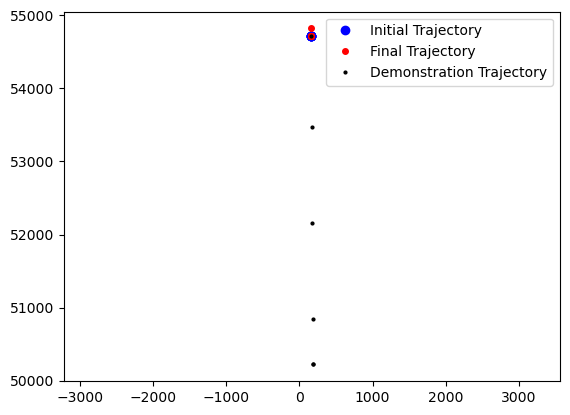

In [ ]:
def traj_opt(trajectory, feature_fcns, theta, params, n_to_differentiate):
    theta = torch.tensor(deepcopy(theta))
    traj = torch.tensor(deepcopy(trajectory))

    print("theta: ", theta)

    def reward_fcn_differentiable(positions, rest, params, theta):
        features = torch.tensor([feature_fcn(positions, rest, params) for feature_fcn in feature_fcns])
        return torch.dot(theta, features)
    
    # Wrap the reward function up with the rest of the trajectory that we're not optimizing so we can just differentiate over the positions
    temp_f = functools.partial(reward_fcn_differentiable, rest=traj[:, n_to_differentiate:], params=params, theta=theta)

    learning_rate = 0.001 
    diff = 1.0 
    while diff > 1e-3:
        traj_for_grad = traj[:, 0:n_to_differentiate].clone().detach().requires_grad_(True) # a copy to use to get the gradient

        # Get the gradient of the reward function wrt the positions
        grad = jacobian(temp_f, traj_for_grad)
        
        print("reward: ", temp_f(traj[:, 0:n_to_differentiate]))
        perturbed_traj = traj[:, 0:n_to_differentiate] 
        perturbed_traj[-1, 1] += 100
        print("perturbed: ", perturbed_traj)
        print("reward perturbed: ", temp_f(perturbed_traj))
        print("grad: ", grad)


        # Update the trajectory. don't update the initial position
        traj[1:, 0:n_to_differentiate] += learning_rate * grad[1:, :]

        # Calculate the difference between the new and old trajectory
        diff = torch.linalg.norm(grad)
        print("diff: ", diff)

    return traj

# Okay so now we have a theta, and we have a way to optimize a trajectory given a theta
# Let's try to optimize a trajectory given a theta and see what happens

# We'll start with a trajectory that is all at the start point 
sub_index = 100
initial_traj = deepcopy(train_sub_trajectories[sub_index, :, :])
initial_traj[:, 0] = initial_traj[0, 0]
initial_traj[:, 1] = initial_traj[0, 1]
final_traj = traj_opt(initial_traj, normalized_feature_fcns, theta, params, n_to_differentiate)
plt.plot(initial_traj[:, 0], initial_traj[:, 1], 'bo', label="Initial Trajectory", markersize=6)
plt.plot(final_traj[:, 0], final_traj[:, 1], 'ro', label="Final Trajectory", markersize=4)
plt.plot(train_sub_trajectories[sub_index, :, 0], train_sub_trajectories[sub_index, :, 1], 'ko', label="Demonstration Trajectory", markersize=2)
plt.legend()
plt.axis('equal')

array([54719.2, 53475.4, 52153.1, 50849.7, 50222.2, 50222.3])